In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as kl
from tensorflow.keras.applications import resnet50

Questions? message rsuemats@ucsc.edu or yoshisada#1439 on discord

In [ ]:
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as K
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications import NASNetLarge

In [ ]:
train = unpickle("./train.pkl")
test = unpickle("./test.pkl")
print(train["data"].shape)
print(train["label"].shape)
print(test["data"].shape)
print(test)

(10000, 12288)
(10000,)
(2000, 12288)
{'data': array([[ 89,  76, 113, ..., 159, 156, 159],
       [119, 129, 132, ..., 201, 164, 124],
       [117, 112, 116, ...,  48, 111, 142],
       ...,
       [ 11,  30,  14, ...,  67,  70,  69],
       [  8,   5,   4, ..., 115, 113, 132],
       [133, 130, 121, ...,  97,  95,  86]], dtype=uint8)}


In [ ]:
# label dictionary: this maps label integer to the name of the animal
label2name = {1: 'dog',
              2: 'rabbit',
              3: 'deer',
              4: 'elephant',
              5: 'horse',
              6: 'squirrel',
              7: 'tiger',
              8: 'wolf',
              9: 'chimpanzee',
              10: 'panda'}

In [ ]:
# this plot one image given the image index
def show_image(idx, train, label2name=label2name):
    img = train["data"][idx]
    img = np.dstack((img[:4096], img[4096:8192], img[8192:])).reshape(64,64,3)
    plt.imshow(img)
    plt.title(label2name[train["label"][idx]])
    plt.show()

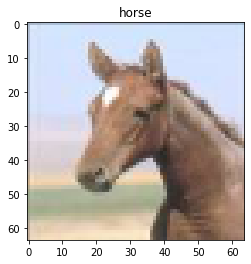

(10000, 64, 64, 3)


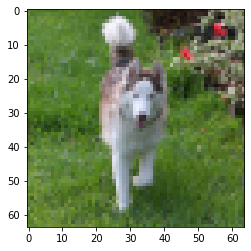

In [ ]:
show_image(2, train)

img = train["data"][0]
trainx = train["data"].reshape(train["data"].shape[0], 64,64,3)
print(trainx.shape)
for i in range(0,trainx.shape[0]):
    img = train["data"][i]
    trainx[i] = np.dstack((img[:4096], img[4096:8192], img[8192:])).reshape(64,64,3)

trainy = train["label"]

testx = test["data"].reshape(test["data"].shape[0], 64,64,3)

plt.imshow(trainx[4])
plt.show()
randomize = random.sample(range(trainx.shape[0]),trainx.shape[0])
trainx = trainx[randomize]
trainy = trainy[randomize]
trainy = trainy - 1

x_train = trainx[:8000]
y_train = trainy[:8000]
x_test = trainx[8000:]
y_test = trainy[8000:]

In [ ]:
def preprocess_data(X, Y):
    X = K.applications.densenet.preprocess_input(X)
    Y = K.utils.to_categorical(Y)
    return X, Y

In [ ]:
print(x_train.shape)
x_train, y_train = preprocess_data(x_train, y_train)
print(y_train.shape)
x_test, y_test = preprocess_data(x_test, y_test)

(8000, 64, 64, 3)
(8000, 10)


In [ ]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications import NASNetLarge
initializer = K.initializers.he_normal()
input_tensor = K.Input(shape=(64, 64, 3))
resized_images = K.layers.Lambda(lambda image: tf.image.resize(image, (299, 299)))(input_tensor)
model = K.applications.DenseNet201(include_top=False,
                                   weights='imagenet',
                                   input_tensor=resized_images,
                                   input_shape=(299, 299, 3),
                                   pooling='max',
                                   classes=10)
output = model.layers[-1].output
flatten = K.layers.Flatten()
output = flatten(output)
layer_256 = K.layers.Dense(units=256,
                           activation='elu',
                           kernel_initializer=initializer,
                           kernel_regularizer=K.regularizers.l2())
output = layer_256(output)
dropout = K.layers.Dropout(0.5)
output = dropout(output)
softmax = K.layers.Dense(units=10,
                         activation='softmax',
                         kernel_initializer=initializer,
                         kernel_regularizer=K.regularizers.l2())
output = softmax(output)
model = K.models.Model(inputs=input_tensor, outputs=output)

In [ ]:
model.compile(
         optimizer=K.optimizers.Adam(learning_rate=1e-4),
         loss='categorical_crossentropy',
         metrics=['accuracy'])

In [ ]:
lr_reduce = K.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                          factor=0.6,
                                          patience=2,
                                          verbose=1,
                                          mode='max',
                                          min_lr=1e-7)
early_stop = K.callbacks.EarlyStopping(monitor='val_accuracy',
                                       patience=7,
                                       verbose=1,
                                       mode='max')
checkpoint = K.callbacks.ModelCheckpoint('submission.h5',
                                         monitor='val_accuracy',
                                         verbose=1,
                                         save_weights_only=False,
                                         save_best_only=True,
                                         mode='max',
                                         save_freq='epoch')

In [ ]:
train_datagen = K.preprocessing.image.ImageDataGenerator(
                                          rotation_range=40,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          shear_range=0.2,
                                          zoom_range=0.2,
                                          horizontal_flip=True,
                                          fill_mode='nearest')
train_generator = train_datagen.flow(x_train,
                                     y_train,
                                     batch_size=32)
val_datagen = K.preprocessing.image.ImageDataGenerator(
                                        horizontal_flip=False
                                        )
val_generator = val_datagen.flow(x_test,
                                 y_test,
                                 batch_size=32)
train_steps_per_epoch = x_train.shape[0] // 32
val_steps_per_epoch = x_test.shape[0] // 32
history = model.fit(train_generator,
                    steps_per_epoch=train_steps_per_epoch,
                    validation_data=val_generator,
                    validation_steps=val_steps_per_epoch,
                    epochs=20,
                    shuffle=True,
                    callbacks=[lr_reduce, early_stop, checkpoint],
                    verbose=1)

Epoch 1/20
250/250 [==============================] - 280s 1s/step - loss: 5.6666 - accuracy: 0.6706 - val_loss: 3.4818 - val_accuracy: 0.9123

Epoch 00001: val_accuracy improved from -inf to 0.91230, saving model to submission.h5
Epoch 2/20
250/250 [==============================] - 261s 1s/step - loss: 3.3261 - accuracy: 0.8519 - val_loss: 2.7307 - val_accuracy: 0.9234

Epoch 00002: val_accuracy improved from 0.91230 to 0.92339, saving model to submission.h5
Epoch 3/20
250/250 [==============================] - 261s 1s/step - loss: 2.7543 - accuracy: 0.8798 - val_loss: 2.6496 - val_accuracy: 0.8826

Epoch 00003: val_accuracy did not improve from 0.92339
Epoch 4/20
250/250 [==============================] - 261s 1s/step - loss: 2.4733 - accuracy: 0.9003 - val_loss: 2.3343 - val_accuracy: 0.9143

Epoch 00004: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 00004: val_accuracy did not improve from 0.92339
Epoch 5/20
250/250 [==============================] - 26

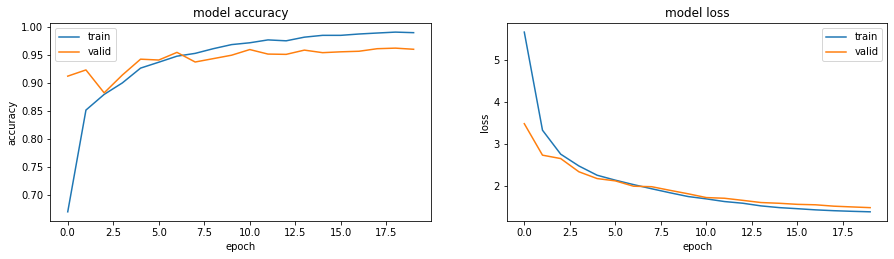

In [ ]:
plt.figure(1, figsize = (15,8))
plt.subplot(221)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.subplot(222)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2000, 64, 64, 3)


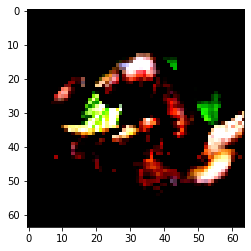

In [ ]:
testx = test["data"].reshape(test["data"].shape[0], 64,64,3)

for i in range(0,testx.shape[0]):
    img = test["data"][i]
    testx[i] = np.dstack((img[:4096], img[4096:8192], img[8192:])).reshape(64,64,3)

# testx = np.pad(testx,((0,0),(5,6),(5,6),(0,0)), 'constant', constant_values = 0)
testx = K.applications.densenet.preprocess_input(testx)
print(testx.shape)

plt.imshow(testx[4])
plt.show()

In [ ]:
predictions = model.predict(testx)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1.5859204e-10 9.9999988e-01 1.3351079e-09 1.6951028e-09 2.5419136e-10
 2.7781066e-09 6.6821542e-08 4.3533652e-11 8.6996843e-10 3.1535721e-09]
[5, 7, 2, 2, 9, 9, 10, 2, 2, 6, 8, 10, 7, 9, 4, 6, 6, 10, 4, 5, 10, 1, 7, 9, 1, 6, 2, 8, 8, 8, 6, 2, 3, 6, 5, 1, 5, 1, 1, 6, 5, 3, 5, 4, 2, 10, 3, 3, 7, 4, 2, 1, 7, 1, 2, 10, 1, 6, 2, 10, 8, 5, 10, 2, 2, 5, 2, 9, 4, 9, 9, 3, 3, 8, 2, 6, 9, 7, 7, 8, 9, 1, 4, 4, 6, 10, 5, 5, 3, 1, 1, 8, 3, 10, 8, 9, 1, 6, 5, 9, 6, 3, 9, 7, 6, 9, 3, 2, 1, 7, 2, 1, 1, 4, 9, 5, 1, 7, 8, 5, 4, 8, 9, 3, 9, 10, 5, 3, 7, 1, 9, 3, 3, 6, 5, 1, 8, 5, 10, 5, 3, 4, 1, 4, 10, 3, 5, 8, 5, 9, 1, 1, 6, 9, 9, 7, 5, 3, 7, 9, 9, 4, 5, 8, 5, 7, 1, 9, 1, 10, 4, 6, 4, 4, 9, 10, 4, 2, 9, 2, 6, 6, 1, 8, 8, 4, 4, 8, 1, 4, 9, 7, 7, 10, 5, 3, 5, 1, 2, 10, 9, 7, 8, 4, 5, 1, 1, 3, 1, 5, 5, 3, 8, 8, 7, 10, 4, 8, 1, 8, 1, 9, 5, 4, 4, 3, 2, 8, 6, 3, 5, 10, 8, 1, 4, 5, 8, 4, 2, 10, 7, 8, 6, 9, 2, 6, 4, 8, 1, 8, 5, 10, 3, 3, 7, 4, 6, 10, 6, 6, 1, 6, 9, 3, 1, 8, 6, 1, 3, 1, 5, 3, 1, 5, 7, 9, 10, 8,

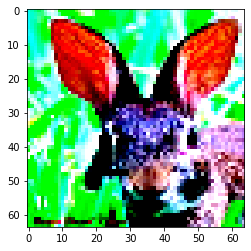

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


horse


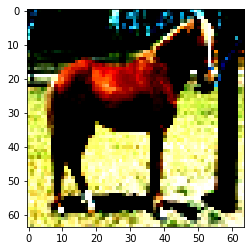

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tiger


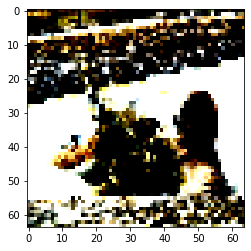

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


rabbit


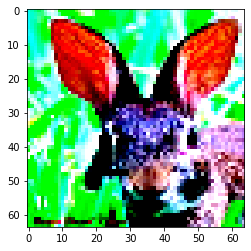

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


rabbit


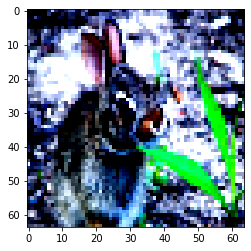

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


chimpanzee


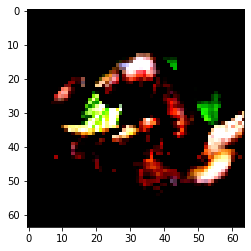

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


chimpanzee


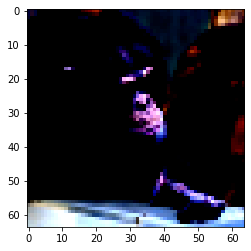

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


panda


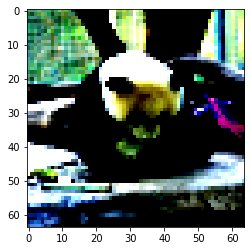

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


rabbit


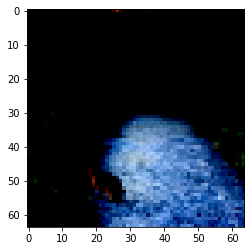

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


rabbit


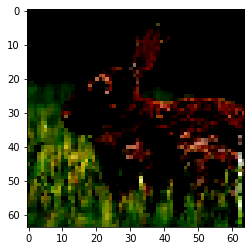

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


squirrel


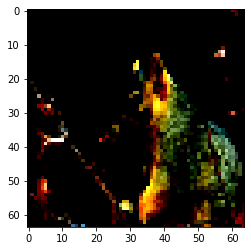

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


wolf


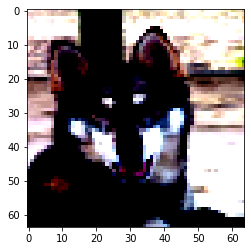

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


panda


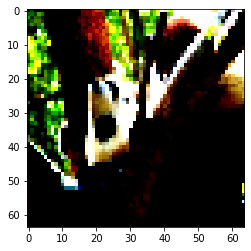

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tiger


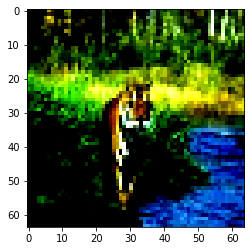

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


chimpanzee


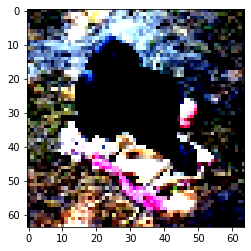

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


elephant


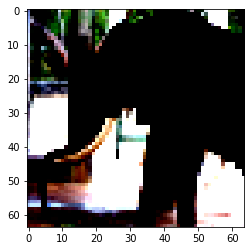

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


squirrel


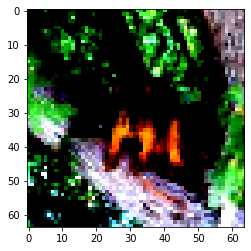

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


squirrel


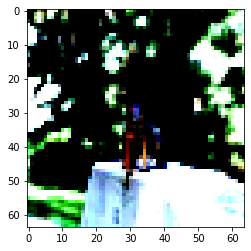

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


panda


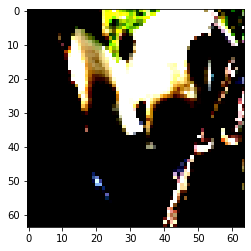

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


elephant


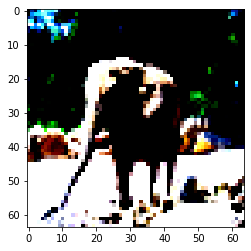

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


horse


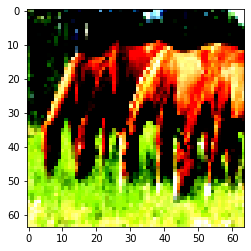

In [ ]:
import csv
import pandas as pd
print(predictions[2])
plt.imshow(testx[2])
pred2 = list()
for i in predictions:
    pred = i.argmax(axis = 0)
    pred2.append(pred+1)

print(pred2)
print(max(pred2))
print(min(pred2))
plt.show()
for i in range(0,20):
    plt.imshow(testx[i])
    print(label2name[pred2[i]])
    plt.show()
my_df = pd.DataFrame(pred2)
my_df.to_csv('submission.csv', index=True, header=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1.3483584e-10 9.9999988e-01 1.2547345e-09 2.1896884e-09 3.0780631e-10
 5.7503406e-09 9.9993152e-08 3.8134759e-11 9.5399477e-10 3.7286165e-09]
[5, 7, 2, 2, 9, 9, 10, 2, 2, 6, 8, 10, 7, 9, 4, 6, 6, 10, 4, 5, 10, 1, 7, 9, 1, 6, 2, 8, 8, 8, 6, 2, 3, 6, 5, 1, 5, 1, 1, 6, 5, 3, 5, 4, 3, 10, 3, 7, 7, 4, 2, 1, 7, 1, 2, 10, 1, 6, 2, 10, 8, 5, 10, 2, 2, 5, 2, 9, 4, 9, 9, 3, 3, 8, 2, 6, 9, 7, 7, 8, 9, 1, 4, 4, 6, 10, 5, 5, 3, 1, 1, 8, 3, 10, 8, 9, 1, 6, 5, 9, 6, 3, 9, 7, 6, 9, 3, 2, 1, 7, 2, 1, 1, 4, 9, 5, 1, 7, 8, 5, 1, 8, 9, 3, 9, 10, 5, 3, 7, 1, 9, 3, 3, 6, 5, 1, 8, 5, 10, 5, 3, 4, 1, 4, 10, 3, 5, 8, 5, 9, 1, 1, 6, 9, 9, 7, 5, 3, 7, 9, 9, 4, 5, 8, 5, 7, 1, 9, 1, 10, 4, 6, 3, 4, 9, 10, 4, 2, 9, 2, 6, 6, 1, 8, 8, 4, 4, 8, 1, 4, 9, 7, 7, 10, 5, 3, 5, 1, 2, 10, 9, 7, 8, 4, 5, 1, 1, 3, 1, 5, 5, 3, 8, 8, 7, 10, 4, 8, 1, 8, 1, 9, 5, 4, 4, 3, 2, 8, 6, 3, 5, 10, 8, 1, 4, 5, 1, 4, 2, 10, 7, 8, 6, 9, 2, 6, 4, 8, 1, 8, 5, 10, 3, 3, 7, 4, 6, 10, 6, 6, 1, 6, 9, 3, 1, 8, 6, 1, 3, 1, 5, 3, 1, 5, 7, 9, 10, 8,

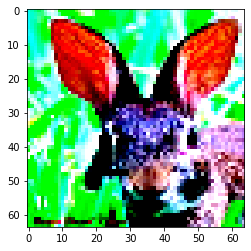

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


horse


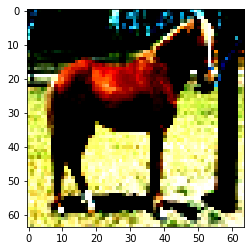

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tiger


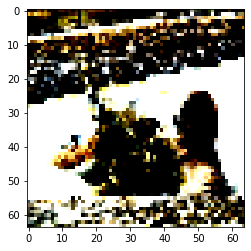

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


rabbit


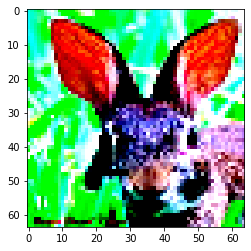

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


rabbit


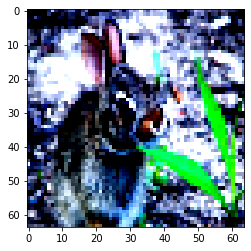

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


chimpanzee


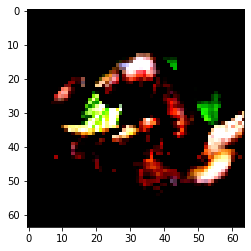

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


chimpanzee


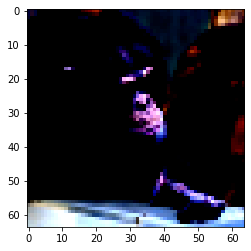

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


panda


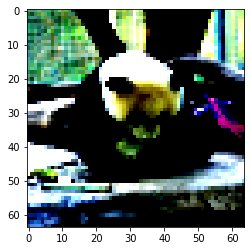

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


rabbit


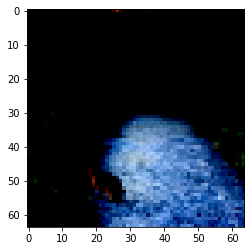

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


rabbit


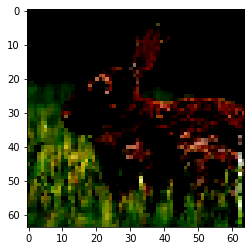

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


squirrel


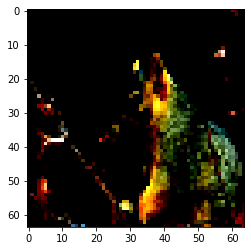

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


wolf


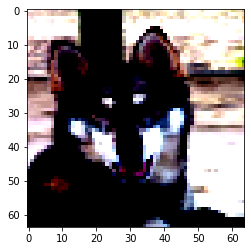

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


panda


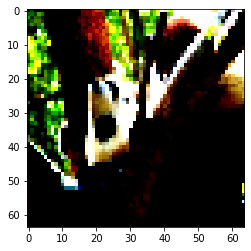

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tiger


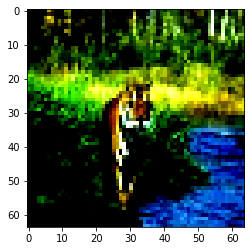

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


chimpanzee


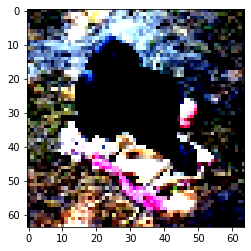

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


elephant


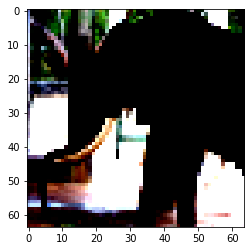

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


squirrel


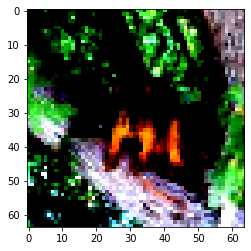

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


squirrel


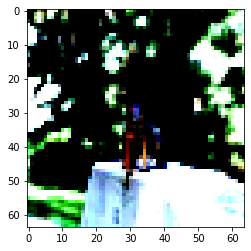

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


panda


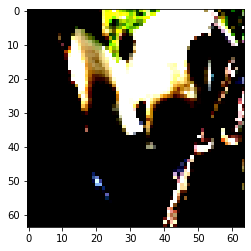

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


elephant


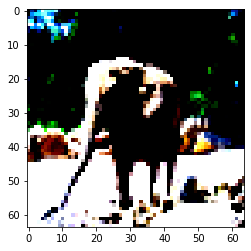

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


horse


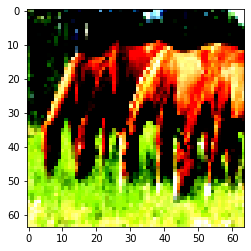

In [ ]:
from keras.models import load_model
model = load_model('./submission.h5')
model.compile(
         optimizer=K.optimizers.Adam(learning_rate=1e-3),
         loss='categorical_crossentropy',
         metrics=['accuracy'])
predictions = model.predict(testx)

print(predictions[2])
plt.imshow(testx[2])
pred2 = list()
for i in predictions:
    pred = i.argmax(axis = 0)
    pred2.append(pred+1)

print(pred2)
print(max(pred2))
print(min(pred2))
plt.show()
for i in range(0,20):
    plt.imshow(testx[i])
    print(label2name[pred2[i]])
    plt.show()
my_df = pd.DataFrame(pred2)
my_df.to_csv('submission2.csv', index=True, header=False)

In [ ]:
with open('./submission.csv', 'r') as t1, open('submission2.csv', 'r') as t2:
    fileone = t1.readlines()
    filetwo = t2.readlines()

with open('update.csv', 'w') as outFile:
    for line in filetwo:
        if line not in fileone:
            outFile.write(line)